# Explore Zenodo community

In [1]:
from zenodoExplorer.zenexp import ze

recIDs = [10835267, 10712131]
with open("api.key", "r") as keyFile:
    ACCESS_TOKEN = keyFile.readline().rstrip()

ze = ze(ACCESS_TOKEN, recIDs)
ze.read_zdb()
ze.zdb.to_pd('AtomicConfigs')

,desc
tag,
ac1@10835267,"EC:EMC liquid PBC, isolated mols, volume scans..."
ac1@10712131,"EC:VC:PC:EMC:DMC:DEC mol clusters, 25% of all ..."
ac2@10712131,"EC:VC:PC:EMC:DMC:DEC mol clusters, 7% of all n..."


In [2]:
ze.zdb.to_pd('TrainData')

,at_conf,ab_init_code,ab_init_theo
tag,,,
td1@10835267,ac1@10835267,CASTEP,PBE-D2
td2@10835267,ac1@10835267,CP2K,PBE-D3
td1@10712131,ac1@10835267,VASP,B97-D3BJ
td2@10712131,ac1@10712131,PSI4,B97-D3BJ
td3@10712131,ac1@10712131,PSI4,wB97X-D3BJ
td4@10712131,ac2@10712131,PSI4,wB97X-D3BJ


In [3]:
ze.zdb.to_pd('MLIPs')

,tr_data,ml_code,ml_settings,fit_prop
tag,,,,
ml1@10835267,td1@10835267,GAP,"DS, Rcut 3/6","energy, forces, virial"
ml2@10835267,td1@10835267,GAP,"DTS, Rcut 3/6","energy, forces, virial"
ml3@10835267,td2@10835267,GAP,"DS, Rcut 3/6","energy, forces, virial"
ml4@10835267,td2@10835267,GAP,"DTS, Rcut 3/6","energy, forces, virial"
ml1@10712131,td1@10712131,MACE,"Layers 2, Rcut 6+6","energy, forces"
ml2@10712131,td2@10712131,MACE,"Layers 2, Rcut 6+6","energy, forces"
ml3@10712131,td3@10712131,MACE,"Layers 2, Rcut 6+6","energy, forces"
ml4@10712131,td4@10712131,MACE,"Layers 2, Rcut 6+6","energy, forces"


In [4]:
ze.zdb.to_pd('MDSims')

,pes_model,md_code,md_system,md_no_at,md_ensmb,md_step,md_len,md_temp,md_pres
tag,,,,,,,,,
md1@10835267,ml4@10835267,LAMMPS,"0%, 33%, 67%, 100% EC:EMC",1000,NPT,1.0 fs,1.0 ns,300 K,1 atm
md2@10835267,ml4@10835267,LAMMPS,"0%, 33%, 67%, 100% EC:EMC",1000,NPT,1.0 fs,1.0 ns,350 K,1 atm
md1@10712131,ml3@10712131,ASE,EMC,1000,NPT,1.0 fs,1.0 ns,298 K,1 atm
md2@10712131,ml3@10712131,ASE,"0%, 33%, 67%, 100% EC:EMC",1000,NPT,0.5 fs,0.5-1.0 ns,"298, 298, 298, 313 K",1 atm
md3@10712131,ml4@10712131,ASE,"0%, 33%, 67%, 100% EC:EMC",1000,NPT,1.0 fs,0.5 ns,"298, 298, 298, 313 K",1 atm
md4@10712131,ml1@10712131,ASE,"0%, 33%, 67%, 100% EC:EMC",1000,NPT,1.0 fs,0.8-1.0 ns,"298, 298, 298, 313 K",1 atm
md5@10712131,ml2@10712131,ASE,"0%, 33%, 67%, 100% EC:EMC",1000,NPT,1.0 fs,0.8-1.0 ns,"298, 298, 298, 313 K",1 atm


In [5]:
ze.zdb.plot()

# Get MD trajectories

In [14]:
import os
from aseMolec import pltProps as pp

def get_all_thermo(tag):
    thermo = {}
    flist = ze.read_dat_files(tag, ext='.thermo')
    for f in flist:
        aux = os.path.basename(f)
        key = os.path.splitext(aux)[0]
        thermo.update({key: pp.loadtxttag(f)})
    return thermo

tags = ['md1@10835267', 'md2@10712131', 'md4@10712131', 'md5@10712131']
thermo = dict()
for tag in tags:
    thermo[tag] = get_all_thermo(tag)

# from old paper, will be replaced with MACE MD
pp.rename_key(thermo['md1@10835267'], 'TimeStep', 'Time')
pp.rename_key(thermo['md1@10835267'], 'v_mdensity', 'Density')
pp.rename_key(thermo['md1@10835267'], 'c_compMSD[4]', 'MSD')
pp.convert_units(thermo['md1@10835267'], 'Density', 'g/cm$^3$', 1.0)
pp.convert_units(thermo['md1@10835267'], 'MSD', 'A$^2$', 1.0)
thermo['md1@10835267'] = {
    k_new : thermo['md1@10835267'][k_old]
    for k_old, k_new in zip(['67EMC_300K', '25EC_50EMC_300K', '57EC_29EMC_300K', '100EC_300K'],
                            ['npt_000conEC_298K', 'npt_033conEC_298K', 'npt_066conEC_298K', 'npt_100conEC_313K'])
}

for tag in thermo:
    pp.convert_units(thermo[tag], 'Time', 'ps', 0.001)

def_cols = ['tab:red', 'tab:orange', 'tab:green', 'tab:blue']

# Compare MD trajectories

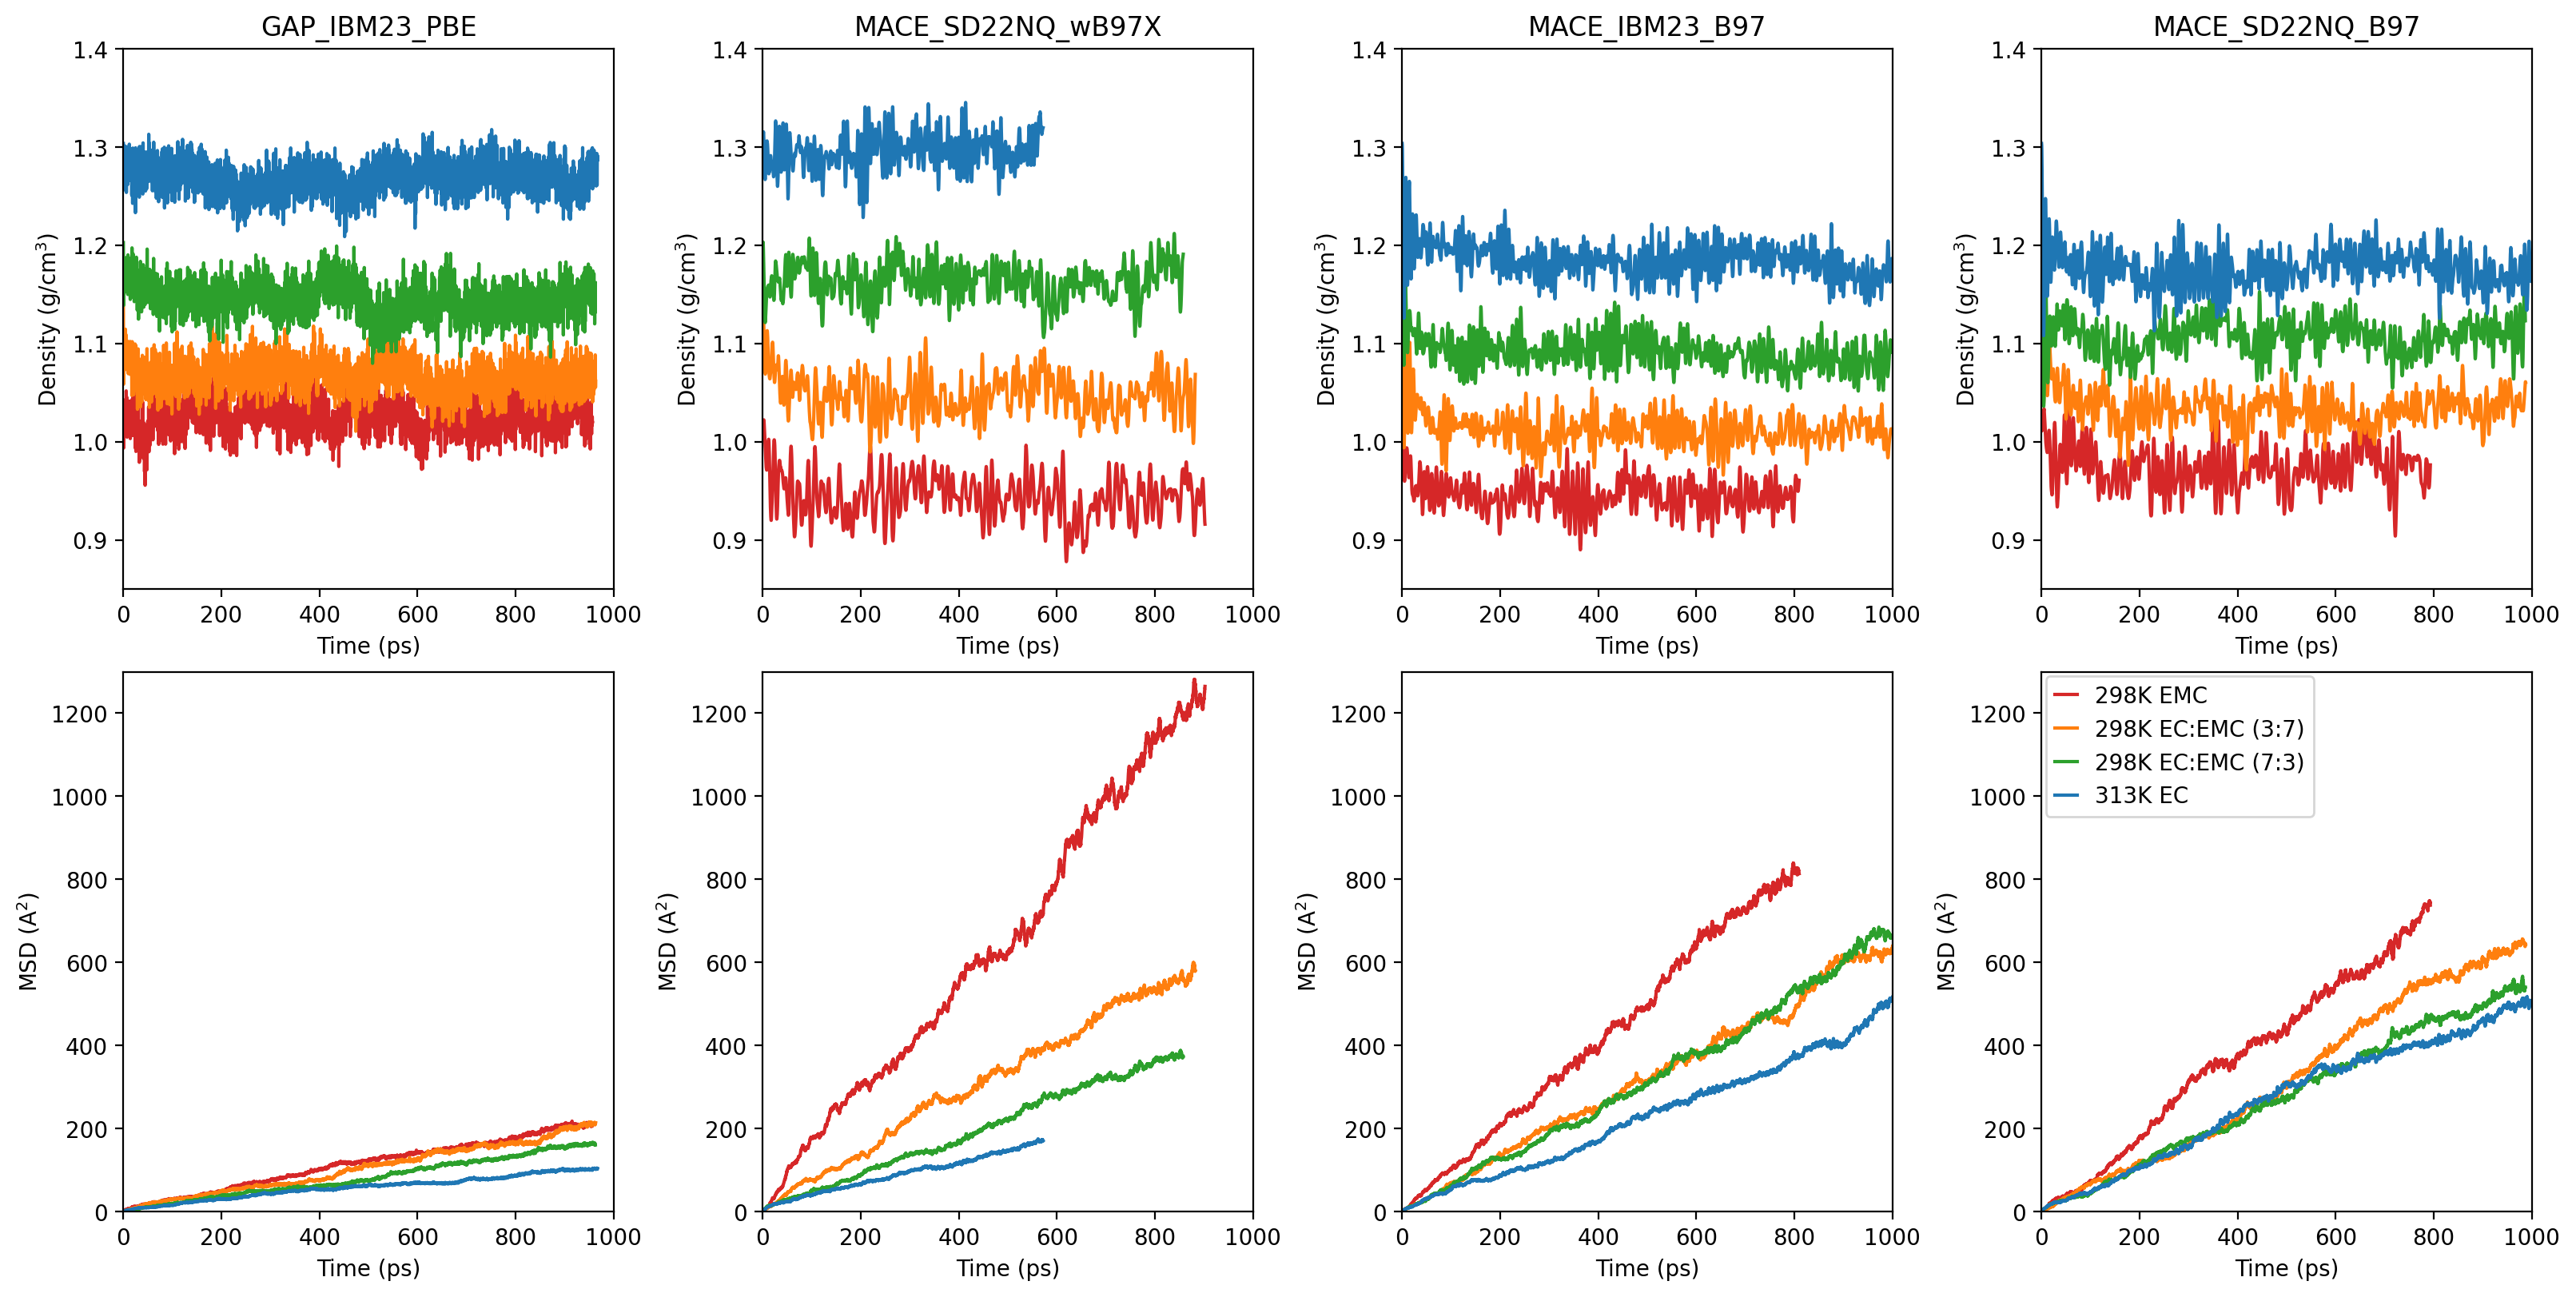

In [17]:
from matplotlib import pyplot as plt
from aseMolec import pltProps as pp
import ase.units
densfact = (ase.units.m/1.0e2)**3/ase.units.mol

fig, axes = plt.subplot_mosaic(mosaic='ABCD;EFGH', figsize=(16,8), dpi=200, layout='constrained')

# Density
for tag, panel, title in zip(tags, ['A', 'B', 'C', 'D'], ['GAP_IBM23_PBE', 'MACE_SD22NQ_wB97X', 'MACE_IBM23_B97', 'MACE_SD22NQ_B97']):
    plt.sca(axes[panel])
    for i, k in enumerate(thermo[tag]):
        pp.simpleplot(thermo[tag][k], 'Time', 'Density', byKey=True, color=def_cols[i])
    plt.xlim([0,1000])
    plt.ylim([0.85,1.4])
    plt.title(title)

# Diffusivity
for tag, panel in zip(tags, ['E', 'F', 'G', 'H']):
    plt.sca(axes[panel])
    for i, k in enumerate(thermo[tag]):
        pp.simpleplot(thermo[tag][k], 'Time', 'MSD', byKey=True, color=def_cols[i])
    plt.xlim([0,1000])
    plt.ylim([0,1300])

plt.legend(['298K EMC', '298K EC:EMC (3:7)', '298K EC:EMC (7:3)', '313K EC'], handlelength=1, loc='upper left', borderaxespad=0.2)


# To Do List

- train MACE on td2@10835267
- run MD/300K all compositions with new model